In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

In [2]:
from tensorflow import keras
from tensorflow.keras.utils import to_categorical

In [3]:
import cv2

# from utils.loader import Loader
# from utils.image import draw_around_box, draw_pose, get_area_of_interest
# from utils.trainer import Trainer

# import tensorflow.compat.v1 as tf
# tf.disable_v2_behavior()
import tensorflow as tf

# from tensorflow.keras.preprocessing import image
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import pickle

In [4]:
tf.__version__

'2.3.1'

In [5]:
def show(img):
    plt.imshow(img)
    plt.show()

In [6]:
# when need to load
filename = 'training_data_d_0.025'
infile = open(filename,'rb')
training_data_img = pickle.load(infile)
infile.close()

In [7]:
X_train = []
y_train = []

In [8]:
for features, label in training_data_img:
    X_train.append(features)
    y_train.append(label)
IMG_SIZE_y = 150
IMG_SIZE_x = 150

# X = np.repeat(np.array(X)[..., np.newaxis], 3, -1)
X_train = np.array(X_train).reshape(-1, IMG_SIZE_x, IMG_SIZE_y, 1)
y_train = np.array(y_train).reshape((-1,1))

In [9]:
# when need to load
filename = 'test_data_d_0.025'
infile = open(filename,'rb')
test_data_img = pickle.load(infile)
infile.close()

In [10]:
X_test = []
y_test = []

In [11]:
for features, label in test_data_img:
    X_test.append(features)
    y_test.append(label)
IMG_SIZE_y = 150
IMG_SIZE_x = 150

# X = np.repeat(np.array(X)[..., np.newaxis], 3, -1)
X_test = np.array(X_test).reshape(-1, IMG_SIZE_x, IMG_SIZE_y, 1)
y_test = np.array(y_test).reshape((-1,1))

In [12]:
# when need to load
filename = 'validate_data_d_0.025'
infile = open(filename,'rb')
validate_data_img = pickle.load(infile)
infile.close()

In [13]:
X_validate = []
y_validate = []

In [14]:
for features, label in validate_data_img:
    X_validate.append(features)
    y_validate.append(label)
IMG_SIZE_y = 150
IMG_SIZE_x = 150

# X = np.repeat(np.array(X)[..., np.newaxis], 3, -1)
X_validate = np.array(X_validate).reshape(-1, IMG_SIZE_x, IMG_SIZE_y, 1)
y_validate = np.array(y_validate).reshape((-1,1))

In [15]:
y_validate.shape

(969, 1)

In [16]:
X_validate.shape

(969, 150, 150, 1)

In [17]:
X_test.shape

(969, 150, 150, 1)

In [18]:
X_train.shape

(2907, 150, 150, 1)

In [19]:
u, c = np.unique(y_train, return_counts=True)
print(c)


[2223  684]


In [20]:
y_train = to_categorical(y_train)

In [21]:
train_datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

In [22]:
test_datagen = ImageDataGenerator(rescale=1./255)

In [23]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [24]:
it = train_datagen.flow(X_train, y_train, batch_size = 32)

In [25]:
test_it = test_datagen.flow(X_test, y_test, batch_size = 32)

In [26]:
val_it = test_datagen.flow(X_validate, y_validate, batch_size = 32)

In [27]:
def act(): return LeakyReLU(alpha=0.1)
def reg(l1=0.0, l2=0.3): return tf.keras.regularizers.l1_l2(l1=l1, l2=l2)

In [28]:
model = Sequential()
model.add(Conv2D(32, (5, 5), strides=(2, 2), activation=LeakyReLU(alpha=0.1), kernel_regularizer=reg(), bias_regularizer=reg(), input_shape=(150, 150, 1)))

model.add(BatchNormalization())

model.add(Conv2D(48, (5, 5), strides=(1, 1), dilation_rate=(1, 1), activation=LeakyReLU(alpha=0.1), kernel_regularizer=reg(), bias_regularizer=reg()))
model.add(BatchNormalization())

model.add(Conv2D(64, (5, 5), dilation_rate=(1, 1), activation=LeakyReLU(alpha=0.1), kernel_regularizer=reg(), bias_regularizer=reg()))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Conv2D(142, (6, 6), dilation_rate=(1, 1), activation=LeakyReLU(alpha=0.1), kernel_regularizer=reg(), bias_regularizer=reg()))
model.add(Dropout(0.3))
    
model.add(Conv2D(128, (1, 1), dilation_rate=(1, 1), activation=LeakyReLU(alpha=0.1), kernel_regularizer=reg(), bias_regularizer=reg()))
model.add(Dropout(0.3))
model.add(Conv2D(2, (1,1), activation='softmax', dilation_rate=(1, 1), bias_regularizer=reg(l2=0.2)))
model.add(Flatten())
model.add(Dense(2, activation='sigmoid'))

In [29]:
model.compile(loss=keras.losses.binary_crossentropy,
              optimizer=keras.optimizers.Adam(learning_rate=1e-7),
              metrics=['accuracy'])

In [30]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 73, 73, 32)        832       
_________________________________________________________________
batch_normalization (BatchNo (None, 73, 73, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 69, 69, 48)        38448     
_________________________________________________________________
batch_normalization_1 (Batch (None, 69, 69, 48)        192       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 65, 65, 64)        76864     
_________________________________________________________________
batch_normalization_2 (Batch (None, 65, 65, 64)        256       
_________________________________________________________________
dropout (Dropout)            (None, 65, 65, 64)        0

In [31]:
history = model.fit(it, steps_per_epoch =len(X_train) // 32, epochs = 30, validation_data=val_it)

Epoch 1/30
90/90 [==============================] - 16s 175ms/step - loss: 95.9683 - accuracy: 0.2793 - val_loss: 96.0848 - val_accuracy: 0.0000e+00
Epoch 2/30
90/90 [==============================] - 8s 91ms/step - loss: 95.9167 - accuracy: 0.2786 - val_loss: 96.0365 - val_accuracy: 0.0000e+00
Epoch 3/30
90/90 [==============================] - 8s 93ms/step - loss: 95.8600 - accuracy: 0.2936 - val_loss: 95.9885 - val_accuracy: 0.0000e+00
Epoch 4/30
90/90 [==============================] - 8s 94ms/step - loss: 95.8073 - accuracy: 0.3033 - val_loss: 95.9404 - val_accuracy: 0.0000e+00
Epoch 5/30
90/90 [==============================] - 8s 94ms/step - loss: 95.7559 - accuracy: 0.3217 - val_loss: 95.8926 - val_accuracy: 0.0010
Epoch 6/30
90/90 [==============================] - 8s 94ms/step - loss: 95.6948 - accuracy: 0.3440 - val_loss: 95.8456 - val_accuracy: 0.0196
Epoch 7/30
90/90 [==============================] - 8s 94ms/step - loss: 95.6429 - accuracy: 0.3544 - val_loss: 95.7990 - va

In [32]:
# preds = model.predict(test_it , steps=10)

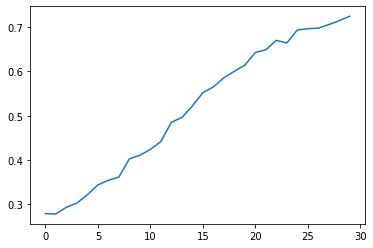

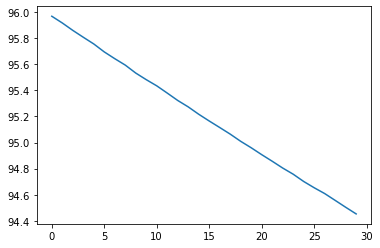

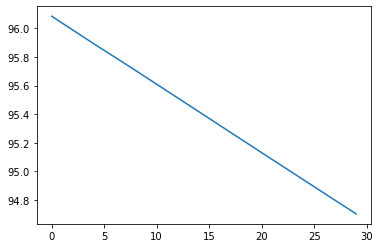

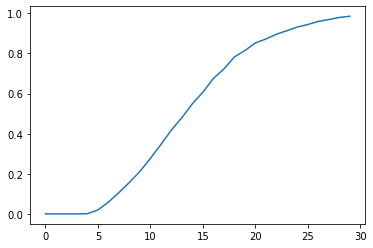

In [33]:
plt.plot(history.history['accuracy'])
plt.show()
plt.plot(history.history['loss'])
plt.show()
plt.plot(history.history['val_loss'])
plt.show()
plt.plot(history.history['val_accuracy'])

In [34]:
# from numba import cuda
# cuda.select_device(0)
# cuda.close()